# Solving the MountainCar problem

In this task we have a car, located at the bottom of a valley. The car can go to left or right with full throttle or do nothing.
Here the environment is a bit changed because the reward function is redefined to provide a dense feedback. In the original game -1 reward is received all the time. However this makes the convergence slow. 

To speed it up, the reward function will be:

$$r = \sin(p' \cdot 3) \cdot 0.45 + 0.55$$

where $p'$ is the position in the next state.

**State:** the $x$ coordinate of the car and the speed

**Action:** full throttle to left or right (left: 0, do nothing: 1 \[we will ignore this\], right: 2)

The solution will use the radial basis functions for feature extraction. You will implement Q-learning with a linear function approximator (based on the features) to train the Q-function.

In [ ]:
#!pip install gymnasium

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym  # this library contains environments defined in advance

<img src="http://drive.google.com/uc?export=view&id=1XJj3Bju-mqZO8S9JT9QEfMAnZqAjj5X2" width=45%>
<img src="RL-day4-1.png" width=45%>

### Feature extraction

In [4]:
def init_weights(num_coarse):
    # num_coarse - how coarse is the feature space
    # the Q-function will be represented by a linear-approximator
    # initialize the weights matrix 
    # each weight correpsonds to a specific feature
    
    # ----- implement this single line -----
    return np.zeros((num_coarse * num_coarse, 2)) # create a numpy matrix with the appropriate size, now we have only two actions!


def center_points(num_coarse):
    # in case of the radial functions we need center points
    # the state space is 2D
    max_speed = 0.07
    min_speed = -0.07
    max_pos = 0.6
    min_pos = -1.2
    speeds = np.linspace(min_speed, max_speed, num_coarse)  
    positions = np.linspace(min_pos, max_pos, num_coarse)
    sigma = (max_pos - min_pos) / num_coarse
    ratio = (max_pos - min_pos) / (max_speed - min_speed)  # the scale of the speed and position is different, this would harm the exponential terms calculated from the speed, causing no effect of the speed
    return positions, speeds, sigma, ratio


def feature(state, centers):
    # calculate the feature values
    # take into account the ratio too
    pos, velocity = state  # position, velocity
    positions, speeds, sigma, ratio = centers
    
    # ----- implement the radial basis features according to the formula -----
    # Slower loop version 
    f = np.zeros((len(positions), len(speeds)))
    for i, p in enumerate(positions):
        for j, s in enumerate(speeds):
            distance_pos = (pos - p) ** 2
            distance_vel = ((velocity - s) * ratio) ** 2
            f[i, j] = np.exp(-(distance_pos + distance_vel) / (2 * sigma ** 2))
    
    return f  # the feature values in a numpy matrix

In [ ]:
def feature_fast(state, centers):
    pos, velocity = state  # Convert state components into numpy arrays
    positions, speeds, sigma, ratio = centers

    # Ensure that positions and speeds are at least 2D arrays for broadcasting
    positions = positions.reshape(-1, 1) if positions.ndim == 1 else positions
    speeds = speeds.reshape(-1, 1) if speeds.ndim == 1 else speeds
    
    # Vectorized computation of distances
    # Calculate the squared differences for positions and speeds, adjust for ratio, then sum
    pos_distances = np.sum((positions - pos)**2, axis=1)  # sum over the feature dimensions after broadcasting
    vel_distances = np.sum((speeds - velocity)**2, axis=1) * ratio**2  # sum and adjust by ratio squared

    # Combine the position and velocity distances
    combined_distances = pos_distances[:, np.newaxis] + vel_distances  # Combine using broadcasting

    # Calculate the Gaussian RBF for each combination of center
    f = np.exp(-combined_distances / (2 * sigma ** 2))

    return f  # the feature values in a numpy matrix

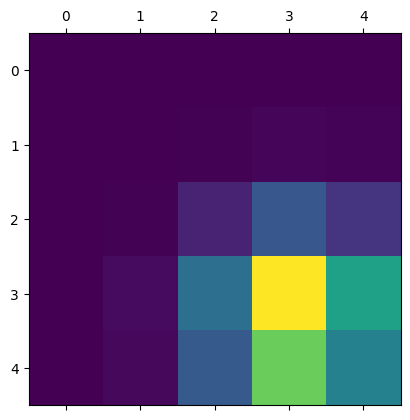

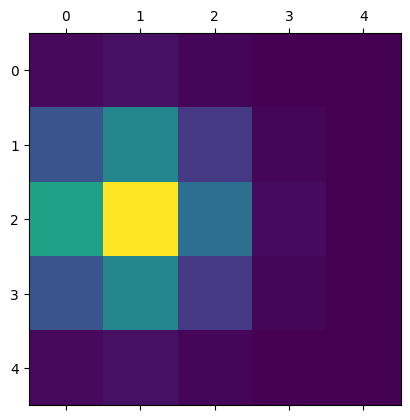

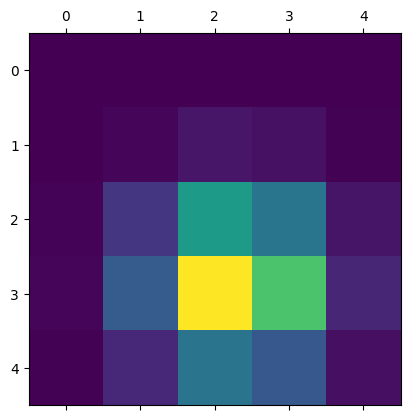

In [20]:
# testing the feature function
# this is a visualization to understand better the feature space
# the feature hashigh value at the location of the state in the state space
# the state space is spanned by the position and velocity of the car
# therefore the state space is 2-dimensional
cps = center_points(5)

state = (0.3, 0.04)
f = feature(state, cps)
plt.matshow(f)

state = (-0.3, -0.04)
f = feature(state, cps)
plt.matshow(f)

state = (0.1, 0.01)
f = feature(state, cps)
plt.matshow(f)

You should see for the first case:

<img src="http://drive.google.com/uc?export=view&id=1WyxbvdQm43yxuTRARRRpV5PtxwmF950G" width=45%>
<img src="RL-day4-2.png" width=45%>

### Saving/loading weights

In [5]:
# At the end we can save the weights.
# This is good for experimenting with the agent after training.

def save_weights(weights, file_path):
    np.save(file_path, weights, allow_pickle=False)


def load_weights(file_path):
    return np.load(file_path, allow_pickle=False)

### Functions for training

In [6]:
def Q_sa(state, action, weights, centers):
    # this is the Q-function
    # ----- implement this -----
    f = feature(state, centers).flatten() # calculate the features for the current state
    return np.dot(weights[:, action // 2], f) # calculate the Q-value from the weights, features and action (action: 0, 1)


def policy(state, weights, centers, epsilon):
    # epsilon-greedy for choosing the next action
    # return 0 for left, 2 for right (1 is ignored now)
    # ----- implement this -----
    if np.random.rand() < epsilon:
        action = np.random.choice([0, 2])
    else:
        q_left = Q_sa(state, 0, weights, centers)
        q_right = Q_sa(state, 2, weights, centers)
        action = 0 if q_left > q_right else 2

    return action  # the sampled action


def update(state, action, r, state_next, weights, centers, gamma, alpha):
    # Q-learning update rule for the linear approximation
    # ----- implement this -----
    q_current = Q_sa(state, action, weights, centers)
    q_next_left = Q_sa(state_next, 0, weights, centers)
    q_next_right = Q_sa(state_next, 2, weights, centers)
    q = max(q_next_left, q_next_right) # choose the best Q-value
    u = r + gamma * q # one-step return
    td_error = u - q_current
    f = feature(state, centers).flatten()
    action = action // 2  # action can be 0 or 2 but 2 is not a valid index
    weights[:, action] += alpha * td_error * f # update the weights

### Training the agent

In [3]:
def train():
    # init the environment
    env = gym.make('MountainCar-v0')
    # set the seeds to make the results easier to reproduce
    np.random.seed(0)
    
    
    # hyper-parameters (you can play with this parameters)
    num_iter = 5000
    num_coarse = 10
    epsilon = 1
    alpha = 0.35  # learning rate
    gamma = 0.98
    
    weights = init_weights(num_coarse)
    centers = center_points(num_coarse)

    for counter in range(num_iter):
        state, info = env.reset(seed=1, options={})  # state - [position, velocity]
        done = False
        score = 0  # to see the return (for status log)
        length = 0  # the length of the current episode (for status log)
        max_pos = -1.2  # how much further moved the car in the right direction (for status log)
        while not done:
            length += 1
            action = policy(state, weights, centers, epsilon) # ---- get the action in the current state ----- 
            state_next, _, terminated, truncated , _ = env.step(action) # ----- make one step with the environment -----
            if state_next[0] > max_pos:
                max_pos = state_next[0]  # this will show whether the agent is getting closer to the flag
            reward = np.sin(state_next[0]*3)*0.45+0.55  # redefined reward to get more feedback
            update(state, action, reward, state_next, weights, centers, gamma, alpha)
            score += reward
            state = state_next
            done = terminated or truncated
        epsilon = max(epsilon - 1.0/num_iter , 0.1)  # decrease the epsilon (exploration -> exploitation)
        if counter % 10 == 0:  # logging
            print("{} -> {} -> {} -> {}".format(counter, length,  score, max_pos))
    # saving the weights at the end
    save_weights(weights, "wgt.npy")

In [37]:
train()  # note that you can reach a position of > 0.5 and a reward of > 80

0 -> 200 -> 21.923465579965477 -> -0.38380587100982666
10 -> 200 -> 21.395764655412854 -> -0.3992757499217987
20 -> 200 -> 21.46770514212532 -> -0.40815269947052
30 -> 200 -> 23.336045178224623 -> -0.393688827753067
40 -> 200 -> 22.262270960948186 -> -0.4128190577030182
50 -> 200 -> 20.97503902813742 -> -0.4137741029262543
60 -> 200 -> 21.00032728859109 -> -0.41375109553337097
70 -> 200 -> 26.932905198932264 -> -0.3265358507633209
80 -> 200 -> 22.454929198454835 -> -0.371735543012619
90 -> 200 -> 23.392004245398685 -> -0.37835848331451416
100 -> 200 -> 22.719624097966914 -> -0.39221277832984924
110 -> 200 -> 23.914560914084877 -> -0.2924756109714508
120 -> 200 -> 24.98412600308662 -> -0.31079334020614624
130 -> 200 -> 24.890863421419965 -> -0.27243950963020325
140 -> 200 -> 21.054744709718335 -> -0.43785330653190613
150 -> 200 -> 24.146898323913454 -> -0.33322909474372864
160 -> 200 -> 25.587543062866455 -> -0.2872733473777771
170 -> 200 -> 21.396215737807314 -> -0.3834065794944763
180

### Video for seeing what the agent is doing

In [15]:
def visualize(weights, num_coarse):
    env = gym.make('MountainCar-v0', render_mode='human')
    centers = center_points(num_coarse)
    for counter in range(10):
        done = False
        state, info = env.reset()#(seed=1, options={})  # state - [position, velocity]
        score = 0
        while not done:
            action = policy(state, weights, centers, 0.0)
            state_next, _, terminated, truncated , _ = env.step(action)
            #env.render()
            reward = np.sin(state_next[0]*3)*0.45+0.55
            score += reward
            state = state_next # This was either missing or it was a task to find it
            done = terminated or truncated
        print("At iteration {} the score: {} the state: {}".format(counter+1, score, state[0]))
# Had to change render mode to human, and include random seed, otherwise the results below are
# the same for each round. Also added state to output.

In [16]:
# This will not work on colab but it can run on a common laptop
# No need for gpu and computationally not expensive
weights = load_weights("wgt.npy")
num_coarse = 10
visualize(weights, num_coarse)

At iteration 1 the score: 79.96402351302027 the state: 0.5025877356529236
At iteration 2 the score: 40.67079035475743 the state: 0.5036461353302002
At iteration 3 the score: 87.69934684733866 the state: 0.43464672565460205
At iteration 4 the score: 41.481185472591314 the state: 0.5035475492477417
At iteration 5 the score: 72.00555155732461 the state: 0.5021207928657532
At iteration 6 the score: 71.98965729553957 the state: 0.5000344514846802
At iteration 7 the score: 43.831348569071 the state: 0.505829393863678
At iteration 8 the score: 69.17641700733846 the state: 0.50107342004776
At iteration 9 the score: 86.96221949070137 the state: 0.47538435459136963
At iteration 10 the score: 82.32432059606468 the state: 0.503152072429657
